# Visión por Computador - Práctica 2 - Deep Learning en Computer Vision

#### 12 puntos   |   Fecha de entrega: 15 de Diciembre, 23:59   |   Forma de entrega: a través de la tarea creada en https://pradogrado2425.ugr.es/

### Estudiante: <mark>Guillermo Ramblado Carrasco</mark>

# <font color='blue'>**Ejercicio  3: Transfer Learning y fine-tuning con ResNet50 en el SPR X-Ray Age Prediction Challenge (3.5 points)**
<font color='blue'>En este ejercicio trabajaremos con el _SPR X-Ray Age Prediction Challenge_ de Kaggle (https://www.kaggle.com/competitions/spr-x-ray-age/data). Este dataset consta de $10 702$ radiografías de tórax, y el objetivo es predecir la edad de la persona a partir de la imagen de la radiografía. En esta ocasión, se emplearán $6 702$ imágenes para entrenamiento y $4 000$ para test. Las edades oscilan entre los 18 y los 89 años. Para facilitar el trabajo al alumnado se proporciona una versión procesada de los datos (con resolución $224\times224$, en lugar de $1024\times1024$, y empleando solo ejemplos para los cuales se tiene salida deseada (dado que, al tratarse de una challenge de kaggle, el conjunto de test está disponible pero sin etiquetar)). Estos datos se pueden acceder desde: https://drive.google.com/drive/folders/1hCWfTLs1w0h5kObl6NEIhEtH5VDmmCnj?usp=sharing (se debe emplear una cuenta de la UGR para acceder a dicha URL, y la información allí contenida (directorio `spr-x-ray-age`) se debe incluir en la carpeta `Colab Notebooks`).

<font color='blue'>Se debe emplear un $20\%$ de los datos de entrenamiento para validación, y el rendimiento debe ser evaluado, como mínimo, por medio de $MSE$, $MAE$ y $R^2$ _(coefficient of determination) score_. Se deben justificar las decisiones tomadas, como la elección de la función de pérdida. Del mismo modo, es necesario hacer un `summary()` de las arquitecturas empleadas en cada apartado, indicando qué parámetros/capas/bloques son entrenables y cuáles no lo son (es decir, en cada apartado es imprescindible destacar claramente qué arquitectura exacta se está utilizando, así como qué pesos se están entrenando y cuáles se están congelando).

<font color='blue'>Usaremos un modelo ResNet50 pre-entrenado en ImageNet, y tendremos que realizar los siguientes experimentos en relación a la estrategia de entrenamiento:

<font color='blue'>1. Partimos de ResNet50, adaptamos la cabecera (sustituyendo la cabecera anterior por *una única fully-connected* con el número de neuronas de salida adecuado), y reentrenamos (_from scratch_) la red entera para este nuevo problema. Es decir, partimos de pesos aleatorios para resolver este problema de regresión.

<font color='blue'>2. Partimos de ResNet50, adaptamos la cabecera (empleando la misma del apartado anterior), y entrenamos solo la cabecera incorporada. Es decir, ResNet50 se usa como un mero extractor de características, y los pesos que se entrenan son los de la nueva capa incorporada (manteniendo fijos/congelados todos los demás).  

<font color='blue'>3. Partimos de ResNet50, dejamos que fastai incorpore su cabecera por defecto (véase https://wandb.ai/capecape/imagenette_timm/reports/Checking-Out-the-New-fastai-timm-Integration--VmlldzoxOTMzNzMw o https://docs.fast.ai/vision.learner.html#head-and-model), y entrenamos solo la cabecera incorporada. Es decir, de nuevo, ResNet50 se usa como extractor de características, y los pesos que se entrenan son los de las nuevas capas incorporadas

<font color='blue'>4. Partimos de ResNet50, adaptamos la cabecera (puede ser la del apartado 3.2 o la del 3.3), y hacemos un ajuste fino de toda la red partiendo de los pesos de ResNet50 (preentrenada en ImageNet).



<font color='blue'>Es importante remarcar que estamos intentando resolver un problema de regresión por medio de la reutilización de un modelo pre-entrenado en un problema de clasificación (ImageNet). ¿Tiene sentido hacerlo? ¿Por qué nos sirven pesos entrenados en clasificación para un problema de regresión? ¿No son, acaso, problemáticas muy diferentes?

In [ ]:
# The first thing we should do is to apply hardware acceleration via GPU. So, we have to go to Editar - Configuracion del Cuaderno - Acelerador por Hardware GPU

# Now we SET UP Fastai
!pip install -Uqq fastbook
!pip install nbdev
import fastbook
fastbook.setup_book()
import fastai
import fastcore
print(f'fastcore version {fastcore.__version__} installed')
print(f'fastai version {fastai.__version__} installed')
from nbdev.showdoc import *
from fastai.vision.all import *

fastcore version 1.7.26 installed
fastai version 2.7.18 installed


In [ ]:
# Function to display evaluation metrics
# Developed by Ignacio Oguiza: https://forums.fast.ai/t/plotting-metrics-after-learning/69937

@patch
@delegates(subplots)
def plot_metrics(self: Recorder, nrows=None, ncols=None, figsize=None, **kwargs):
    metrics = np.stack(self.values)
    names = self.metric_names[1:-1]
    n = len(names) - 1
    if nrows is None and ncols is None:
        nrows = int(math.sqrt(n))
        ncols = int(np.ceil(n / nrows))
    elif nrows is None: nrows = int(np.ceil(n / ncols))
    elif ncols is None: ncols = int(np.ceil(n / nrows))
    figsize = figsize or (ncols * 6, nrows * 4)
    fig, axs = subplots(nrows, ncols, figsize=figsize, **kwargs)
    axs = [ax if i < n else ax.set_axis_off() for i, ax in enumerate(axs.flatten())][:n]
    for i, (name, ax) in enumerate(zip(names, [axs[0]] + axs)):
        ax.plot(metrics[:, i], color='#1f77b4' if i == 0 else '#ff7f0e', label='valid' if i > 0 else 'train')
        ax.set_title(name if i > 1 else 'losses')
        ax.legend(loc='best')
    plt.show()

In [ ]:
# defining the paths to images and labels
train_folder = 'gdrive/MyDrive/Colab Notebooks/spr-x-ray-age/train'
test_folder = 'gdrive/MyDrive/Colab Notebooks/spr-x-ray-age/test'
csv_path = 'gdrive/MyDrive/Colab Notebooks/spr-x-ray-age/All_labels.csv'

In [ ]:
if os.path.exists(csv_path):
    print("CSV File exists!")
    # reading the labels dataframe
    '''
    - csv_path : path del archivo CSV a leer
    - dtype : tipo de dato al que deben ser convertidos los datos leídos
    - index_col : nos permite indicar el índice de la columna del archivo CSV que se usará como índice del DataFrame,
    en lugar de generar un índice numérico predeterminado.
    '''
    df = pd.read_csv(csv_path, dtype=float, index_col=0)
    print(f'Dataframe shape: {df.shape}')
else:
    print("File does not exist.")

CSV File exists!
Dataframe shape: (10702, 1)


Efectivamente, el archivo CSV contiene 10702 entradas, que se corresponden justamente con las salidas de las 10702 imágenes del dataset de trabajo, incluyendo tanto entrenamiento como test.

In [ ]:
print(df.head()) #mostrar, por defecto, las 5 primeras filas (indice y valor asociado)
print('\n',df.columns) #columna que maneja el dataframe, en este caso, age, que mantiene las edades de las personas asociadas a las diferentes imágenes

          age
imageId      
0.0      89.0
1.0      72.0
2.0      25.0
3.0      68.0
4.0      37.0

 Index(['age'], dtype='object')


In [ ]:
# defining the dataset paths
train_path = Path(train_folder)
test_path = Path(test_folder)

# reading the folders looking for images
train_files = get_image_files(train_path)
test_files = sorted(get_image_files(test_path))

print(f'{len(train_files)} files were found for training and {len(test_files)} files were found for test')

6702 files were found for training and 4000 files were found for test


In [ ]:
train_path.ls() #rutas de las diferentes imágenes de train

(#6702) [Path('gdrive/MyDrive/Colab Notebooks/spr-x-ray-age/train/000584.png'),Path('gdrive/MyDrive/Colab Notebooks/spr-x-ray-age/train/000582.png'),Path('gdrive/MyDrive/Colab Notebooks/spr-x-ray-age/train/000576.png'),Path('gdrive/MyDrive/Colab Notebooks/spr-x-ray-age/train/000588.png'),Path('gdrive/MyDrive/Colab Notebooks/spr-x-ray-age/train/000591.png'),Path('gdrive/MyDrive/Colab Notebooks/spr-x-ray-age/train/000575.png'),Path('gdrive/MyDrive/Colab Notebooks/spr-x-ray-age/train/000580.png'),Path('gdrive/MyDrive/Colab Notebooks/spr-x-ray-age/train/000577.png'),Path('gdrive/MyDrive/Colab Notebooks/spr-x-ray-age/train/000568.png'),Path('gdrive/MyDrive/Colab Notebooks/spr-x-ray-age/train/000570.png'),Path('gdrive/MyDrive/Colab Notebooks/spr-x-ray-age/train/000572.png'),Path('gdrive/MyDrive/Colab Notebooks/spr-x-ray-age/train/000567.png'),Path('gdrive/MyDrive/Colab Notebooks/spr-x-ray-age/train/000569.png'),Path('gdrive/MyDrive/Colab Notebooks/spr-x-ray-age/train/000579.png'),Path('gdriv

In [ ]:
train_path.ls()[0].name

'000584.png'

Tras ejecutar el anterior código, obtenemos, primeramente, el total de imágenes de train (6702), y a continuación, la ruta de acceso a las diferentes imágenes. Como se puede observar, el nombre de cada imagen se corresponde justamente con el índice empleado para referenciar dicha imagen en el archivo CSV (donde se indica la edad de la persona reflejada en la imagen), descartando claramente los primeros ceros.

Por ende, a la hora de especificar la salida de una imagen (edad de la persona), realizaremos los siguientes pasos:

- Partiendo del path de la imagen, tomamos su nombre, descartando la extensión (.png) y convertimos a un entero, lo que nos permitirá descartar los primeros ceros.
- Tomamos en el dataframe la edad con índice el calculado en el paso previo, que referencia justamente a la imagen inicial.

Ya disponemos de las rutas de acceso a los datos de train y test.

Age varies from 18.0 to 89.0



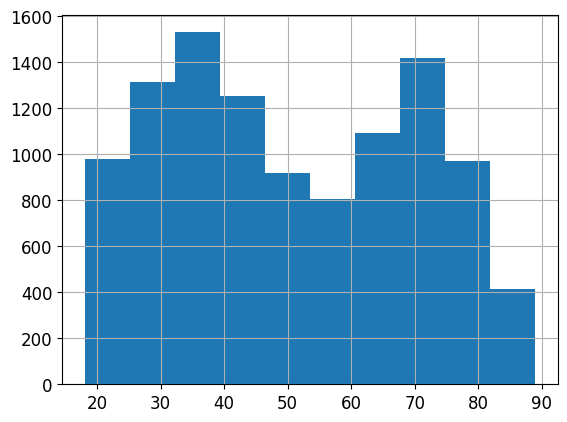

In [ ]:
print(f'Age varies from {df.age.min()} to {df.age.max()}\n')
_=df.age.hist()

El histograma previo nos permite conocer la distribución de las diferentes edades a lo largo de las imágenes, es decir, cuantas imágenes hay disponibles para cada una de las edades que manejamos.

In [ ]:
# function used to retun the label from an image
def label_func(file):
    # takes the file's base name w/o the extension
    basename = int(os.path.basename(str(file)).split('.')[0])

    # searches for the label
    label = int(df.age[basename])

    return label

In [ ]:
doc(DataBlock.dataloaders)

,Type,Default,Details,
source,,,The data source,
path,str,.,Data source and default `Learner` path,
verbose,bool,False,Show verbose messages,
kwargs,,,,
Returns,DataLoaders,,,


Definimos el DatBlock, especificando los siguientes parámetros:

* `blocks` : las entradas y salidas de nuestro modelo serán imágenes y valores objetivo, respectivamente : **ImageBlock** y **RegressionBlock**
* `get_items`: se debe emplear `get_image_files` para tomar las imágenes a partir de su path
* '`get_y`' : en este caso, se debe usar `label_func` para obtener la salida de una imagen de entrada
* `splitter` : separamos de forma aleatoria los datos en train y val, dejando un 20% para validación

A posteriori, generamos los dataloaders de train y val pasando el path del directorio train, y especificando el tamaño de lote a usar, en este caso, 32.

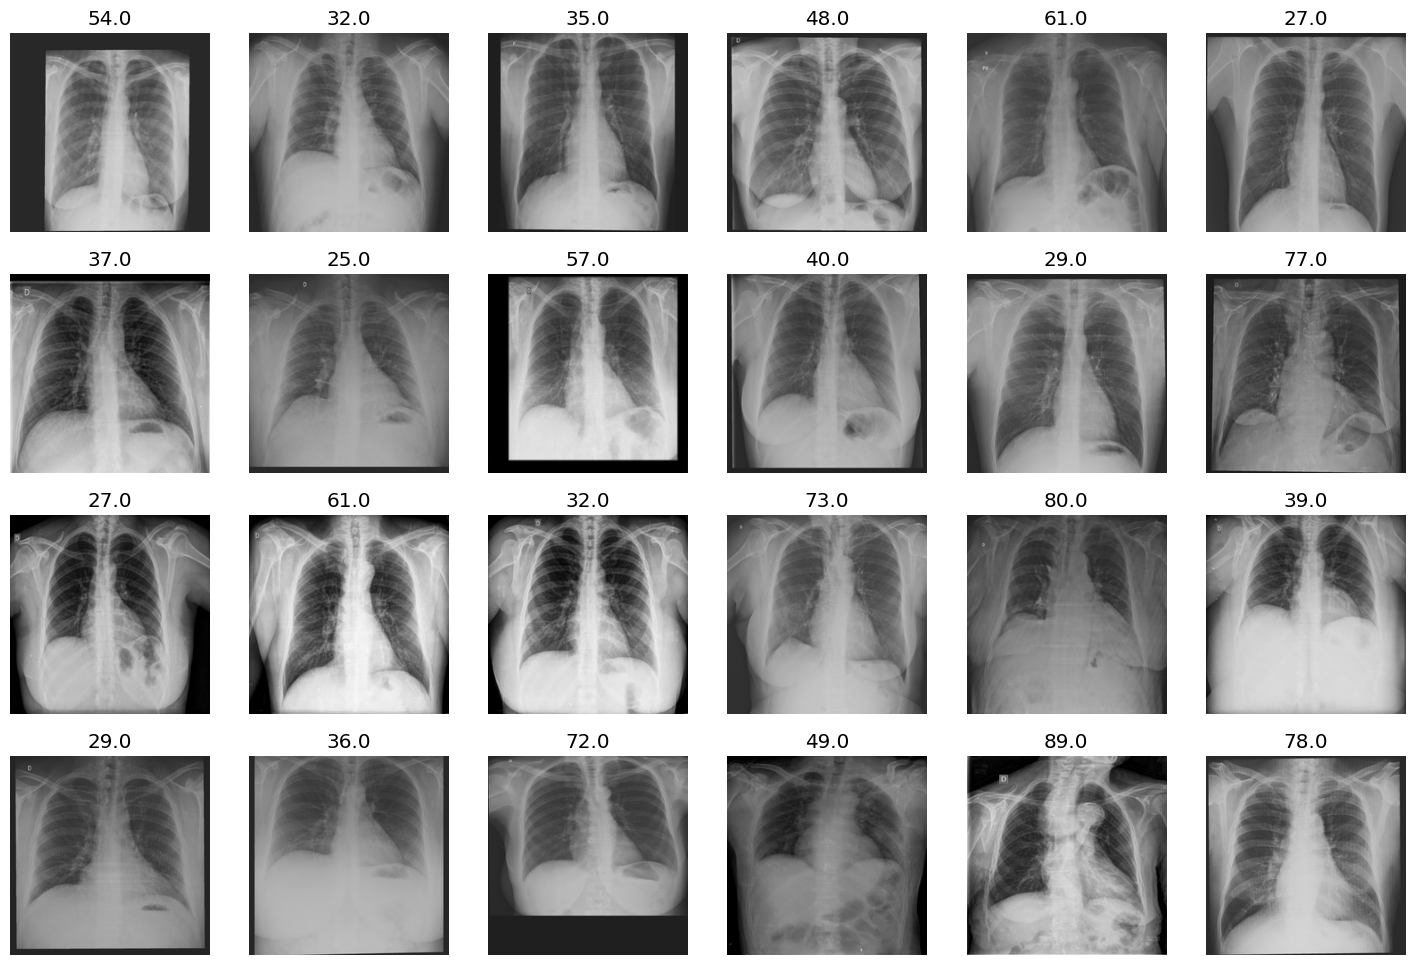

In [ ]:
# defines the image dataloader
dtblk = DataBlock(
    blocks=(ImageBlock,RegressionBlock),
    get_items=get_image_files,
    get_y=label_func,
    splitter=RandomSplitter(valid_pct=0.2, seed=42)
)
#generamos dataloaders de train y val, usando un tamaño de batch de 32
dls = dtblk.dataloaders(train_path,bs=32,num_workers=10)

# shows some samples
dls.show_batch(max_n=24)

# Métricas empleadas

Las métricas empleadas para evaluar el rendimiento del modelo de regresión a entrenar serán las siguientes:


*  **MAE o Mean Absolute Error** : promedio de los valores absolutos de la diferencia, es decir, mide la diferencia media (en valor absoluto) entre una predicción y el valor real.

$$\text{MAE} = \frac{1}{n} \sum_{i=1}^{n} \left| y_i - \hat{y}_i \right|
$$

* **MSE o Mean square error** : igual que MAE, pero en lugar de usar el valor absoluto de la diferencia, se usa el cuadrado de dicha diferencia, penalizando aún más cuanto peor sea la predicción realizada.

$$\text{MSE} = \frac{1}{n} \sum_{i=1}^{n} \left( y_i - \hat{y}_i \right)^2$$

* **R2 o R cuadrada (coeficiente de determinación)** : determina la proporción de variación de los resultados que puede explicar el modelo. Toma valores entre 0 y 1, siendo 1 el mejor (explica el 100% de la variabilidad de los datos) y 0 el peor (no explica ninguna variabilidad).

# Función de pérdida

La función de pérdida a optimizar será en este caso `nn.MSELoss`, que también hemos usado como métrica. Especificamente usaremos `MSELossFlat`, por las mismas razones que comentamos en el problema de clasificación: MSELoss espera que el tensor de predicciones y el tensor con los valores ojetivos tengan la misma dimensión. Sin embargo, al trabajar con lotes, se obtendrán como salida tensores con dimensiones **(batch_size,1)**, mientras que las etiquetas vendrán dadas mediante un tensor **(batch_size)**. Ambos tensores tienen diferentes dimensiones, lo que supondría un problema al evaluar la función de pérdida. Por ende, esta versión aplana ambos tensores.

# Vision Learner

Además, durante el desarrollo de este ejercicio usaremos una red preentrenada, por lo que usaré `vision_learner` en lugar de `Learner`. A diferencia de la clase Learner, una clase más genérica que puede ser empleada para cualquier tipo de problema, `vision_learner` nos ofrece funcionalidades específicas para tareas de visión por computador, además de ser ideal cuando queremos trabajar con redes preentrenadas, como es el caso.




Sus principales parámetros son los siguientes:
* `dls`: dataloaders
* `arch`: arquitectura del modelo a entrenar
* `normalize`:  especificar si queremos normalizar los datos de entrada o no, tal que en el caso de utilizar `normalize=True` y `pretrained=True`, se aplicará `Normalization` sobre el dls pasado como parámetro al método `vision_learner`. Sin embargo, esta normalización no se aplicará sobre el dls en el caso de emplear un modelo no preentrenado, siendo en este caso necesario agregar manualmente `Normalization` a la hora de definir el dls.
* `pretrained` : especificar si queremos o no trabajar con un modelo preentrenado. Por defecto está, **True**
* `loss_func` : función de pérdida a optimizar
* `opt_func` : algoritmo empleado para optimizar la función de pérdida. Por defecto se usa **Adam**
* `metrics` : list de métricas a emplear
* `cute` : nos permite especificar hasta qué punto del modelo base queremos usar. Por defecto, fastai corta el modelo base en un punto adecuado.
* `weights` : conjunto de pesos preentrenados que se usarán para inicializar el modelo. Por defecto **None**
* `custom_head` : nos permite utilizar una cabecera diferente a la que añade por defecto fastai
* `n_out` : nº de salidas del modelo. Por defecto, **None**, lo que implica que se utilizará el dataloader pasado como parámetro para conocer las salidas.
* `train_bn` :  especificar si queremos o no entrenar las capas BatchNormalization del backbone, en el caso de emplear un modelo preentrenado. Por defecto está a **True**, es decir, no se congelan las capas BatchNorm

Si `pretrained=True` y `weights=None`, cargará los pesos preentrenados de ImageNet1K_V2


Además, es importante indicar que si usamos un modelo preentrenado, es decir, `pretrained=True` al definir el learner, Fastai **congelará automáticamente las capas del backbone** de dicho modelo, que son justamente las capas que han sido preentrenadas.

Consultando el código fuente del `vision_learner`, se ha detectado lo siguiente:


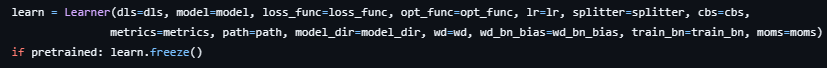

Efectivamente, al indicar que queremos usar un modelo preentrenado, se realiza `learn.freeze()` antes de obtener el learner generado por `vision_learner()`, congelando todas las capas del backbone del modelo, haciendo que el optimizador actualice únicamente los parámetros de las capas finales que se han añadido como cabecera.

Al usar un modelo preentrenado, `vision_learner` eliminará la última capa del modelo (conocida como cabecera), ya que está adaptada para el dataset inicial sobre el que se ha preentrenado dicho modelo, y la reemplazará por una o varias nuevas capas con pesos aleatorios, fijándole un tamaño apropiado para el nuevo dataset sobre el que estamos trabajando.

# Cabecera añadida por defecto

En el caso de no especificar la cabecera a adherir al cuerpo del modelo, es decir, dejando `custom_head=None`, Fastai asigna una **nueva cabecera por defecto** al modelo preentrenado que se quiera emplear, usando el método `create_head`:

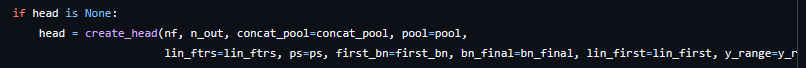

Los valores por defecto de ciertos parámetros se pueden apreciar en el siguiente código fuente:

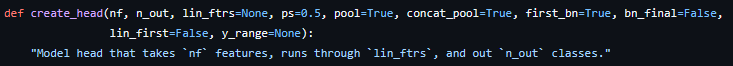

La cabecera creada por defecto está conformada por las siguientes capas:
* **AdaptativeConcatPool2d**
* **Flatten**
* 2 bloques de **BatchNorm+Dropout+Linear+ReLu**

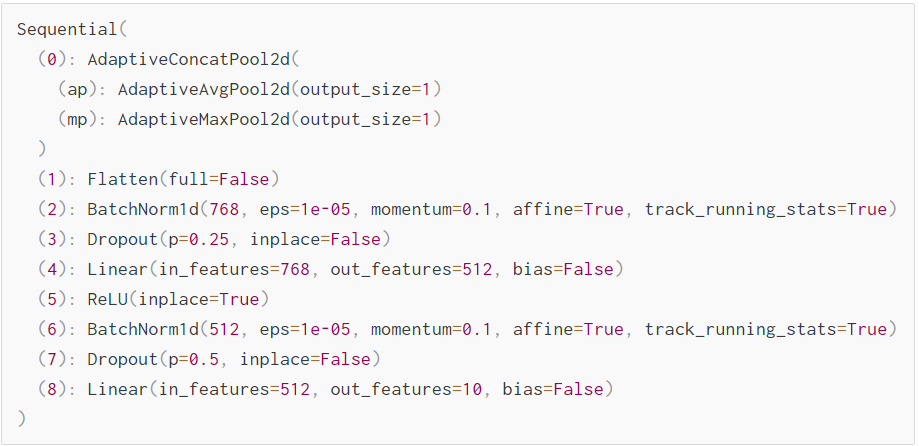

Es importante indicar que nuestro modelo estará conformado principalmente por dos partes:
* 1ª parte, conocido como **backbone**, parte de la red que extrae las características de la imagen. Equivalente a `learn.model[0]`
* 2ª parte, conocido como **cabecera**, toma las características extraídas por el backbone y las adapta para la tarea final. Esta parte es totalmente dependiente de la tarea que queremos realizar. Equivalente a `learn.model[1]`

En nuestro caso, usaremos como modelo preentrenado ResNet50. La estructura clásica de una ResNet es la siguiente:
1. Una **primera convolución** con stride 2, seguida de un **MaxPooling** con mismo stride, reduciendo resolución.
2. **4 etapas** tal que:
  - Cada etapa está conformada por un nº de bloques residuales
  - Cada etapa opera con una resolución diferente
  - Al pasar de una etapa a la siguiente, se reduce a la mitad las dimensiones de la imagen, y se duplica el nº de canales de dicha imagen, todo ello implementado en el primer bloque residual de cada etapa. La única excepción es la primera etapa, en la que no se reduce la resolución de la imagen ya que venimos de aplicar un max_pooling, capa que ya ha realizado dicha tarea.
  - Los bloques residuales de una misma etapa emplean un mismo nº de filtros.

3. **Average Pooling** seguida de una **capa fully-connected**.

Cada bloque residual está conformado por una serie de convoluciones. Inicialmente se diseñaron a partir de dos capas convoluciones 3x3, aunque se propuso como alternativa un **diseño en cuello de botella**, equivalente a emplear, en lugr de 2 convoluciones 3x3, **3 convoluciones 1x1,3x3 y 1x1**, respectivamente.



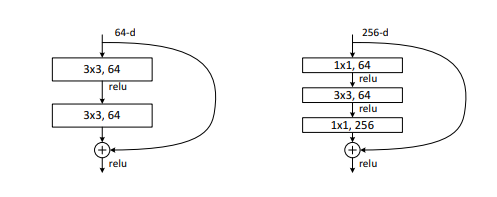

Más especificamente, ResNet50 es una versión que emplea bloques residuales siguiendo este nuevo diseño en cuello de botella, empleando en cada una de las 4 etapas 3,4,6 y 3 bloques residuales, respectivamente. Esto supondría un total de 16 bloques residuales, cada bloque conformado por 3 convoluciones, dando lugar a un cúmulo de 48 capas convolucionales, además de la convolución inicial y la última capa fully-connected. En definitiva, una ResNet de 50 capas, de ahí su nombre.

In [ ]:
doc(vision_learner)

,Type,Default,Details,
dls,,,,
arch,,,,
normalize,bool,True,,
n_out,NoneType,None,,
pretrained,bool,True,,
weights,NoneType,None,,
loss_func,NoneType,None,,
opt_func,function,Adam,,
lr,float,0.001,,
splitter,NoneType,None,,


Definiré una lista en la que guardaré los modelos entrenados en los siguientes apartados, con el objetivo de compararlos y poder sacar conclusiones.

In [ ]:
learners=[]

## <font color='blue'>3.1 Entrenamos todo ResNet50 _from scratch_, ajustando la cabecera para este problema.

Vamos a proceder a usar el modelo preentrenado ResNet50, pero cambiando la cabecera que añade por defecto fastai.
A la hora de añadir mi propia cabecera a dicho modelo, tendré que asegurarme de que ésta enlace bien con la última capa convolucional del backbone del modelo y con las salidas que esperamos tener teniendo en cuenta el dataset de trabajo.

La ResNet50 que emplearemos ha sido preentrenada sobre ImageNet, definida de la siguiente forma:



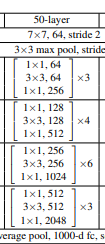

Se puede ver que la última convolución que emplea este modelo es una convolución 1x1 con 2048 filtros. Por ende, la cabecera añadir estará conformada por las siguientes capas:
1. `AdaptativeAveragePooling(1)` sobre cada uno de los canales, con el objetivo de resumir el grid de cada canal en un solo valor, obteniendo como salida un tensor de dimensiones 1x1x2048.
2. Antes de aplicar la capa lineal, debemos de usar `nn.Flatten()` para aplanar dimensiones y obtener un tensor unidimensional con 2048 elementos.
3. Aplicamos `nn.Linear`, con 2048 nodos de entrada y 1 nodo de salida (edad predicha)

In [ ]:
#personalizo la cabecera que quiero añadir al backbone de ResNet50
custom_head = nn.Sequential(
    nn.AdaptiveAvgPool2d(1),
    nn.Flatten(),
    nn.Linear(2048,1)
)
learn1 = vision_learner(dls,resnet50,loss_func=MSELossFlat(),metrics=[mae, mse, R2Score()],pretrained=False,custom_head=custom_head)

In [ ]:
learn1.summary()

Sequential (Input shape: 32 x 3 x 224 x 224)
Layer (type)         Output Shape         Param #    Trainable 
                     32 x 64 x 112 x 112 
Conv2d                                    9408       True      
BatchNorm2d                               128        True      
ReLU                                                           
____________________________________________________________________________
                     32 x 64 x 56 x 56   
MaxPool2d                                                      
Conv2d                                    4096       True      
BatchNorm2d                               128        True      
Conv2d                                    36864      True      
BatchNorm2d                               128        True      
____________________________________________________________________________
                     32 x 256 x 56 x 56  
Conv2d                                    16384      True      
BatchNorm2d                        

Tras hacer `learn.summary()` podemos comprobar que efectivamente todas las capas del modelo son entrenables (columna **Trainable**), dando lugar a un total de 23.510.081 parámetros entrenables.

/usr/local/lib/python3.10/dist-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, **torch_load_kwargs

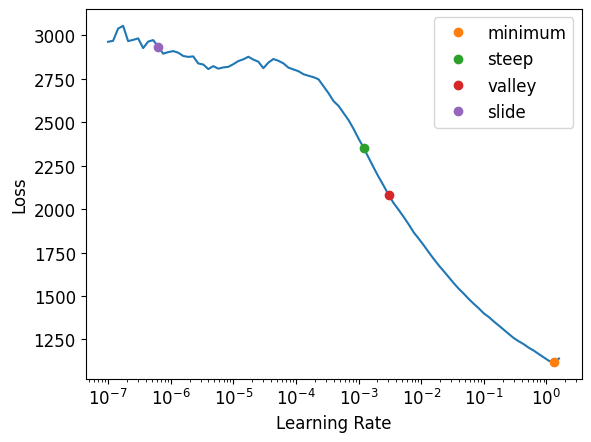

In [ ]:
lrs = learn1.lr_find(suggest_funcs=(minimum, steep, valley, slide))

Como estamos empleando un modelo que no ha sido preentrenado, los parámetros de las capas estarán inicializados aleatoriamente, partiendo de cero. De ahí el descenso brusco que podemos visualizar en la gráfica obtenida tras buscar la tasa óptima, y que muestra como, efectivamente, nuestro modelo mejora más y más a lo largo del entrenamiento, siendo la pérdida cada vez menor.

Más especificamente, los parámetros de dicho modelo, inicializados aleatoriamente, hacen referencia a un punto en el espacio parámetrico sobre el que trabaja la función de pérdida situado lejos del óptimo, por lo que emplear al comienzo tasas cada vez más grandes nos permitirán acercarnos más y más al óptimo, produciendo pérdidas cada vez menores.

A la hora de entrenar el modelo desde scratch (sin transferir el aprendizaje), emplearemos `fit_one_cycle`. Al utilizar un modelo NO preentrenado, no se congelan las capas del backbone, por lo que se entrenarán todas las capas. Además, usaremos `SaveModelCallBack()`, guardando el mejor modelo en cuanto a error de validación.


epoch,train_loss,valid_loss,mae,mse,r2_score,time
0,350.275940,720.479431,21.735462,720.479431,-1.135340,01:14
1,300.990875,303.713074,14.847773,303.713074,0.099862,01:17
2,233.846558,218.507050,11.716812,218.507050,0.352394,01:18
3,208.549576,188.566956,10.701343,188.566956,0.441130,01:13
4,175.243332,156.944458,9.925957,156.944458,0.534852,01:20
5,144.223679,160.236542,9.935009,160.236542,0.525095,01:14
6,132.715103,140.333054,9.324372,140.333054,0.584084,01:16
7,110.268761,153.581070,9.894172,153.581070,0.544820,01:18
8,95.549934,97.905563,7.643752,97.905563,0.709830,01:15
9,89.048294,96.085114,7.572215,96.085114,0.715225,01:16


Better model found at epoch 0 with valid_loss value: 720.4794311523438.
Better model found at epoch 1 with valid_loss value: 303.71307373046875.
Better model found at epoch 2 with valid_loss value: 218.50704956054688.
Better model found at epoch 3 with valid_loss value: 188.56695556640625.
Better model found at epoch 4 with valid_loss value: 156.9444580078125.
Better model found at epoch 6 with valid_loss value: 140.3330535888672.
Better model found at epoch 8 with valid_loss value: 97.90556335449219.
Better model found at epoch 9 with valid_loss value: 96.08511352539062.


/usr/local/lib/python3.10/dist-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, **torch_load_kwargs

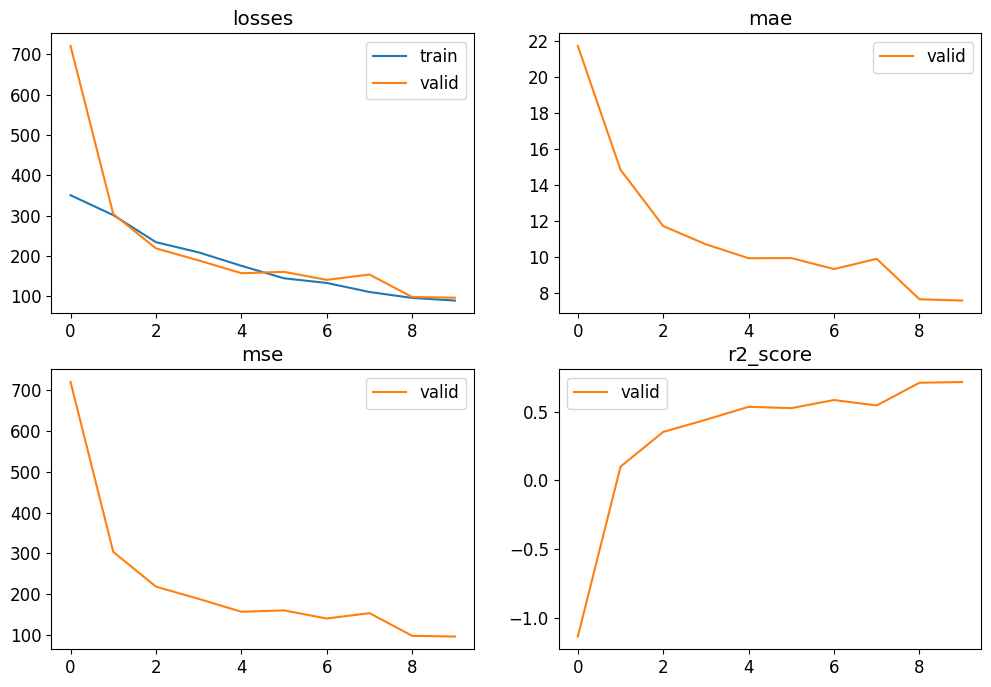

In [ ]:
learn1.fit_one_cycle(10,lr_max=lrs.valley,cbs=SaveModelCallback())
learn1.recorder.plot_metrics()

A la hora de comparar los cuatro modelos, usaré el metodo `validate()` sobre cada uno de ellos, en el apartado de conclusión. Sin embargo, este primer apartado es el único apartado en el que se utiliza un modelo no preentrenado, siendo necesario invocar `validate()`, ya que en el caso de no hacerlo ahora, cuando definamos los learners de los siguientes apartados, se aplicará `Normalization` sobre el dls, que se mantiene igual para todos los apartados, por lo que este primer modelo habrá aprendido a partir de datos no normalizados, y al usar finalmente `validate()`, se validará sobre el dls ahora normalizado, dando resultados muy malos.

In [ ]:
tabla_resultados=[] #lista de diccionarios para posterior comparación de los modelos
error_val,MAE,MSE,R2=learn1.validate()
#validamos el mejor modelo encontrado en cada apartado
tabla_resultados.append({
    "Modelo" : "Apartado 3.1",
    "Error Validación" : error_val,
    "MAE" : MAE,
    "MSE" : MSE,
    "R2" : R2
})

## <font color='blue'>3.2. ResNet50 se usa como extractor de características: Entrenamos solo la cabecera incorporada.



Ahora usaremos el modelo preentrenado, y entrenamos únicamente la cabecera añadida.

1. Definimos el learner usando `pretrained=True`, por lo que Fastai automáticamente congela las capas del backbone. Es importante que `train_bn=False`, para congelar absolutamente todas las capas del backbone, incluyendo las capas BatchNormalization.
2. Entrenamos directamente la cabecera usando `fit_one_cycle`

In [ ]:
learn2 = vision_learner(dls,resnet50,loss_func=MSELossFlat(),metrics=[mae, mse, R2Score()],custom_head=custom_head,train_bn=False)
learn2.summary()

Sequential (Input shape: 32 x 3 x 224 x 224)
Layer (type)         Output Shape         Param #    Trainable 
                     32 x 64 x 112 x 112 
Conv2d                                    9408       False     
BatchNorm2d                               128        False     
ReLU                                                           
____________________________________________________________________________
                     32 x 64 x 56 x 56   
MaxPool2d                                                      
Conv2d                                    4096       False     
BatchNorm2d                               128        False     
Conv2d                                    36864      False     
BatchNorm2d                               128        False     
____________________________________________________________________________
                     32 x 256 x 56 x 56  
Conv2d                                    16384      False     
BatchNorm2d                        

Tras hacer `learn.summary()`, y revisando la columna **Trainable**, podemos comprobar que las únicas capas entrenables son las que conforman la cabecera personalizada.

/usr/local/lib/python3.10/dist-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, **torch_load_kwargs

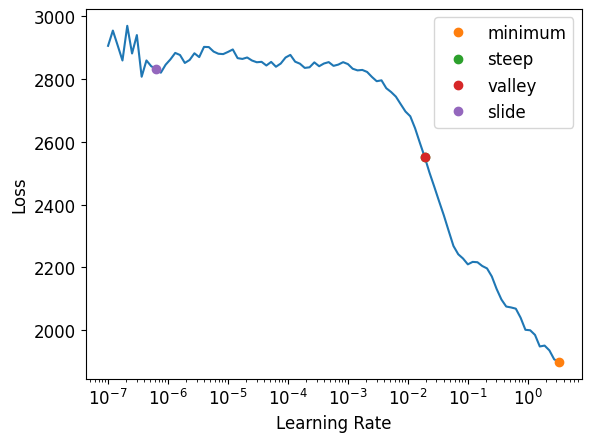

In [ ]:
lrs = learn2.lr_find(suggest_funcs=(minimum, steep, valley, slide))

Para buscar la tasa óptima, se ha entrenado únicamente la cabecera del modelo preentrenado, inicializando aleatoriamente los parámetros de las capas de dicha cabecera y actualizando sólo dichos parámetros, sin tocar los correspondientes de las capas del backbone. Esto es, partiremos de un punto del espacio parámetrico alejado del óptimo, misma situación que en la estrategia previa donde usamos un modelo no preentrenado, haciendo que, al comienzo, tasas cada vez más grandes nos permitan obtener pérdidas más pequeñas.

epoch,train_loss,valid_loss,mae,mse,r2_score,time
0,768.295166,506.264282,18.771948,506.264282,-0.500454,00:46
1,380.574890,304.672791,14.212519,304.672791,0.097018,00:43
2,237.687103,212.665131,11.768681,212.665131,0.369708,00:47
3,194.993057,187.658600,10.984522,187.658600,0.443822,00:47
4,172.953400,182.554092,10.822345,182.554092,0.458951,00:46
5,158.251709,172.238373,10.490868,172.238373,0.489524,00:45
6,159.514618,171.968231,10.446099,171.968231,0.490325,00:47
7,153.153152,168.090164,10.372829,168.090164,0.501818,00:46
8,144.984467,168.236343,10.386460,168.236343,0.501385,00:44
9,142.043228,167.574341,10.352301,167.574341,0.503347,00:48


Better model found at epoch 0 with valid_loss value: 506.2642822265625.
Better model found at epoch 1 with valid_loss value: 304.67279052734375.
Better model found at epoch 2 with valid_loss value: 212.66513061523438.
Better model found at epoch 3 with valid_loss value: 187.65859985351562.
Better model found at epoch 4 with valid_loss value: 182.55409240722656.
Better model found at epoch 5 with valid_loss value: 172.23837280273438.
Better model found at epoch 6 with valid_loss value: 171.96823120117188.
Better model found at epoch 7 with valid_loss value: 168.0901641845703.
Better model found at epoch 9 with valid_loss value: 167.5743408203125.


/usr/local/lib/python3.10/dist-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, **torch_load_kwargs

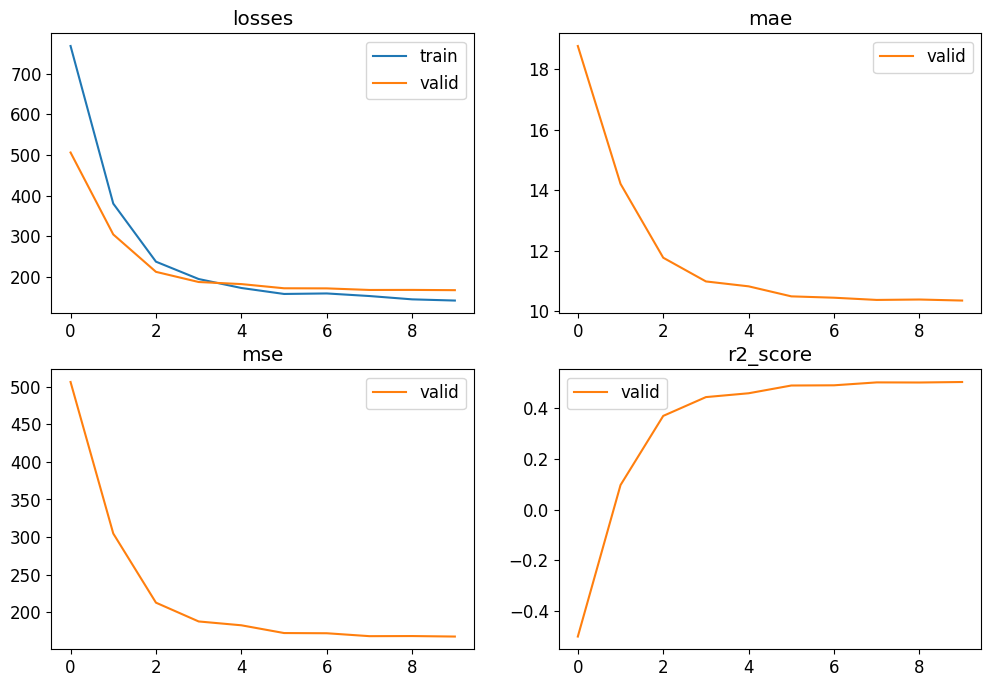

In [ ]:
learn2.fit_one_cycle(10,lr_max=lrs.valley,cbs=SaveModelCallback())
learn2.recorder.plot_metrics()

In [ ]:
learners.append(learn2)

## <font color='blue'>3.3. ResNet50 se usa como extractor de características: Entrenamos solo la cabecera incorporada por defecto por fastai.



Debemos asegurarnos de que el modelo devuelva una única salida, es decir, `n_out=1`. Realmente no hace falta indicarlo ya que, tal y como se  comentó anteriormente, si no se especifica ningún valor, Fastai invocará la función `get_c(dls)` para deducir el nº de salidas:

image.png

En efecto, podemos comprobar como al invocar `get_c(dls)`, obtenemos 1. Aún así, nos aseguraremos de que el modelo devuelva una salida especificando `n_out=1`

In [ ]:
get_c(dls)

1

In [ ]:
learn3 = vision_learner(dls,resnet50,loss_func=MSELossFlat(),metrics=[mae, mse, R2Score()],n_out=1,train_bn=False)
learn3.summary()

Sequential (Input shape: 32 x 3 x 224 x 224)
Layer (type)         Output Shape         Param #    Trainable 
                     32 x 64 x 112 x 112 
Conv2d                                    9408       False     
BatchNorm2d                               128        False     
ReLU                                                           
____________________________________________________________________________
                     32 x 64 x 56 x 56   
MaxPool2d                                                      
Conv2d                                    4096       False     
BatchNorm2d                               128        False     
Conv2d                                    36864      False     
BatchNorm2d                               128        False     
____________________________________________________________________________
                     32 x 256 x 56 x 56  
Conv2d                                    16384      False     
BatchNorm2d                        

Tras el `summary()` previo, validamos el hecho de que se entrenará únicamente la cabecera añadida por defecto por Fastai.

Procedemos a entrenar únicamente la cabecera añadida por defecto usando `fit_one_cycle`. El resto de capas del modelo estarán congeladas.

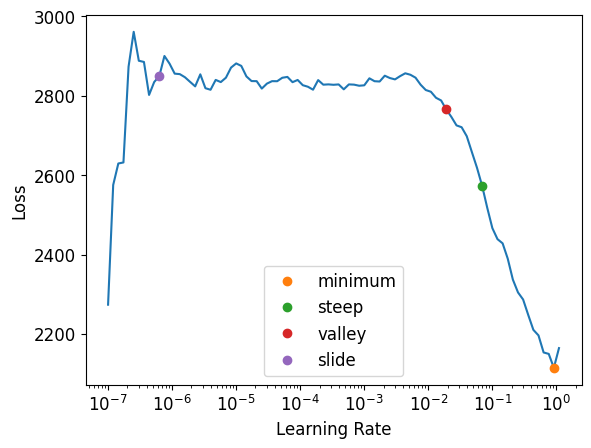

In [ ]:
lrs = learn3.lr_find(suggest_funcs=(minimum, steep, valley, slide))

Por lo mismo comentado en la estrategia previa, el modelo está entrenando sin problemas consiguiendo pérdidas cada vez menores conforme incrementamos la tasa de aprendizaje.

epoch,train_loss,valid_loss,mae,mse,r2_score,time
0,1042.492065,255.134842,12.749539,255.134842,0.243838,00:47
1,231.208847,171.025253,10.562462,171.025253,0.493119,00:45
2,172.333084,161.892471,10.181145,161.892471,0.520187,00:48
3,168.791183,159.038788,10.069288,159.038788,0.528645,00:46
4,157.735046,179.403259,10.631064,179.403259,0.468289,00:47
5,138.631271,151.081619,9.903811,151.081619,0.552228,00:48
6,128.430252,171.685394,10.449165,171.685394,0.491163,00:44
7,113.397331,144.833374,9.643380,144.833374,0.570746,00:46
8,102.435402,255.552475,10.104613,255.552475,0.242600,00:48
9,95.810448,143.157013,9.675897,143.157013,0.575715,00:46


Better model found at epoch 0 with valid_loss value: 255.1348419189453.
Better model found at epoch 1 with valid_loss value: 171.02525329589844.
Better model found at epoch 2 with valid_loss value: 161.89247131347656.
Better model found at epoch 3 with valid_loss value: 159.03878784179688.
Better model found at epoch 5 with valid_loss value: 151.0816192626953.
Better model found at epoch 7 with valid_loss value: 144.8333740234375.
Better model found at epoch 9 with valid_loss value: 143.15701293945312.


/usr/local/lib/python3.10/dist-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, **torch_load_kwargs

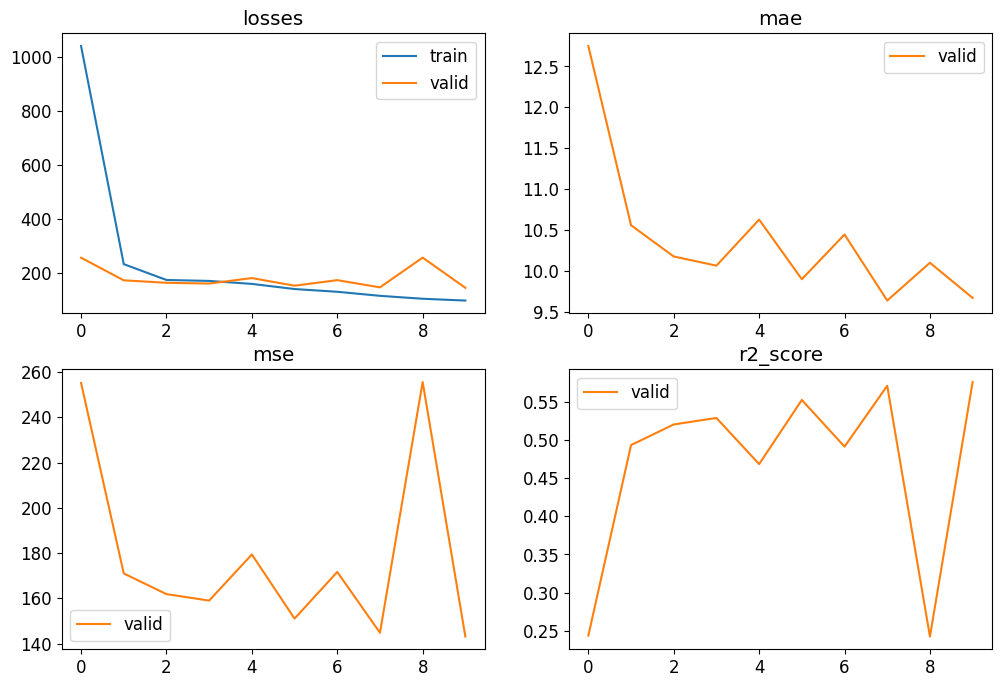

In [ ]:
learn3.fit_one_cycle(10,lr_max=lrs.valley,cbs=SaveModelCallback()) #entrenamos solo la cabecera del modelo
learn3.recorder.plot_metrics()

In [ ]:
learners.append(learn3)

## <font color='blue'>3.4. Hacemos un ajuste fino (fine-tuning) de toda la red partiendo de los pesos de ImageNet.

Como última estrategia, se propone usar ResNet preentrenado y entrenar dicho modelo sobre el nuevo dataset empleando `fine_tune`, que realiza el entrenamiento en dos fases:
1. Comienza entrenando únicamente las capas de la cabecera durante una época (por defecto), con el resto de capas congeladas.
2. Descongela todas las capas del modelo, y entreno el modelo completo durante el nº de épocas indicadas.

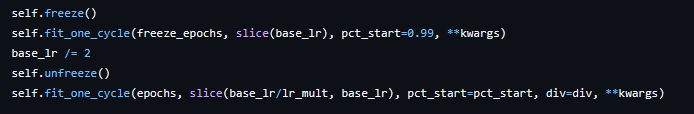

Los parámetros requeridos son los siguientes:
* `epochs` : nº de épocas que se desea entrenar el modelo completo en la segunda fase del proceso de entrenamiento.
* `base_lr` : tasa de aprendizaje inicial
* `freeze_epochs` : nº de épocas que se entrena el modelo en la primera fase, es decir, durante cuántas épocas se va a entrenar únicamente la cabecera del modelo. Por defecto, `freeze_epochs=1`.
* `pct_start` : determina el porcentaje total de las épocas en las que la tasa de aprendizaje va a seguir aumentando, antes de comenzar a disminuir desde su valor máximo hasta su valor base. Por defecto, `pct_start=0.3`
* `wd` : weight decay

Podemos apreciar que en la primera fase del entrenamiento, la tasa de aprendizaje subirá durante el 99% de las épocas, es decir, que prácticamente estamos entrenando la cabecera del modelo usando tasas cada vez más grandes, lo que supondrá actualizaciones más grandes.
Esto nos permite actualizar rápidamente los parámetros de las últimas capas añadidas para que se adapten lo antes posible sobre el dataset de trabajo.

 Sin embargo, en la segunda fase se usará el `pct_start` que indiquemos, por defecto, 0.3, lo que supondrá que sólo durante el primer 30% de las épocas subirá la tasa. Por ende, nos pasaremos la mayor parte del tiempo de esta segunda fase dando pasos cada vez más pequeños, debido a que estaremos trabajando tanto con las capas preentrenadas como con la cabecera (la cual ha sido entrenada de una manera más explosiva en esa primera fase), buscando ajustar todo el modelo de una manera más controlada y estable.

 Además, considero importante hablar sobre las tasas de aprendizaje que se emplearán en la primera y segunda fase del proceso de entrenamiento:
 - Las capas más profundas de nuestro modelo preentrenado no necesitan realmente tasas de aprendizaje tan altas como las últimas añadidas como cabecera. Esto se debe principalmente al hecho de que las primeras capas de un modelo aprenden características muy básicas (detección de bordes, gradiente...) y que suelen ser muy útiles para casi cualquier tarea. Sin embargo, las últimas capas aprenden conceptos más abstractos (como por ejemplo, a reconocer ojos) que dependen mucho más de la tarea a solventar. Por ello, tiene sentido dejar que las últimas capas del modelo se actualicen más rápidamente que las primeras capas.

 -  Por esta razón, se emplean diferentes tasas para cada una de las capas, lo que se conoce como **tasas de aprendizaje discriminativas**, técnica que consiste básicamente en emplear una tasa más pequeña para las primeras capas de la red, y una tasa más alta para las últimas capas (capas más profundas), en especial, para las capas de la cabecera. Para ello, emplearemos `slice`


El objeto `slice` nos permite pasar dos valores:
  - **1º valor** : tasa de aprendizaje de la primera capa del modelo.
  - **2º valor** : tasa de aprendizaje de la capa más profunda del modelo (última capa).

Las capas intermedias usarán, respectivamente, las tasas que se obtienen al generar el conjunto de tasas equidistantes entre la tasa de la primera y última capa fijada. Esto es justamente lo que se hace en la 2º fase del entrenamiento con `fine_tune`, asignando tasas más pequeñas a las capas preentrenadas, y tasas más altas a las capas de la cabecera.


image.png

 Podemos replicar el comportamiento del método `fine_tune` en caso de trabajar con un modelo preentrenado de la siguiente forma:
  - Entrenamos el modelo preentrenado (capas del backbone congeladas automáticamente) usando `fit_one_cycle` unas pocas épocas.
  - Usamos `learn.unfreeze()` para descongelar todo el modelo, y volvemos a entrenar usando dicho método.

Sin embargo, optaré por usar `fine_tune()`, asignando como `base_lr` la tasa máxima encontrada tras usar `learn.lr_find()`, que será justamente el valle.

Por último, comentar que **se empleará la cabecera que añade por defecto** Fastai, ya que nos ha brindado mejores resulltados en validación que los correspondientes a la cabecera personalizada del apartado 3.1.

In [ ]:
learn4 = vision_learner(dls,resnet50,loss_func=MSELossFlat(),metrics=[mae, mse, R2Score()],n_out=1,train_bn=False)
learn4.summary()

Sequential (Input shape: 32 x 3 x 224 x 224)
Layer (type)         Output Shape         Param #    Trainable 
                     32 x 64 x 112 x 112 
Conv2d                                    9408       False     
BatchNorm2d                               128        False     
ReLU                                                           
____________________________________________________________________________
                     32 x 64 x 56 x 56   
MaxPool2d                                                      
Conv2d                                    4096       False     
BatchNorm2d                               128        False     
Conv2d                                    36864      False     
BatchNorm2d                               128        False     
____________________________________________________________________________
                     32 x 256 x 56 x 56  
Conv2d                                    16384      False     
BatchNorm2d                        

Podemos apreciar que sólo serán entrenables las capas de la cabecera del modelo, en este caso, la que añade por defecto Fastai.

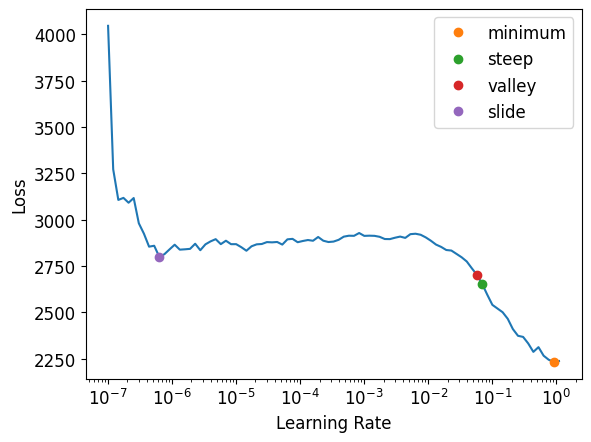

In [ ]:
lrs = learn4.lr_find(suggest_funcs=(minimum, steep, valley, slide))

Procedemos a entrenar el modelo, con el método comentado.

epoch,train_loss,valid_loss,mae,mse,r2_score,time
0,363.488007,171.245758,10.449534,171.245758,0.492466,00:48


Better model found at epoch 0 with valid_loss value: 171.24575805664062.


/usr/local/lib/python3.10/dist-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, **torch_load_kwargs

epoch,train_loss,valid_loss,mae,mse,r2_score,time
0,108.454521,72.596672,6.698343,72.596672,0.784840,01:13
1,85.465759,721.281372,10.797599,721.281372,-1.137716,01:19
2,88.161896,129.881561,9.278514,129.881561,0.615060,01:15
3,81.338631,65.632118,6.297019,65.632118,0.805481,01:13
4,65.478363,65.433456,6.257450,65.433456,0.806070,01:21
5,55.987335,6607.460449,9.440217,6607.460449,-18.583031,01:14
6,43.605831,151.691071,5.531044,151.691071,0.550422,01:17
7,34.829514,44.066227,5.093997,44.066227,0.869398,01:18
8,29.801260,43.980179,5.147013,43.980179,0.869653,01:14
9,24.006134,42.655506,5.044747,42.655506,0.873579,01:19


Better model found at epoch 0 with valid_loss value: 72.59667205810547.
Better model found at epoch 3 with valid_loss value: 65.63211822509766.
Better model found at epoch 4 with valid_loss value: 65.43345642089844.
Better model found at epoch 7 with valid_loss value: 44.066226959228516.
Better model found at epoch 8 with valid_loss value: 43.98017883300781.
Better model found at epoch 9 with valid_loss value: 42.6555061340332.


/usr/local/lib/python3.10/dist-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, **torch_load_kwargs

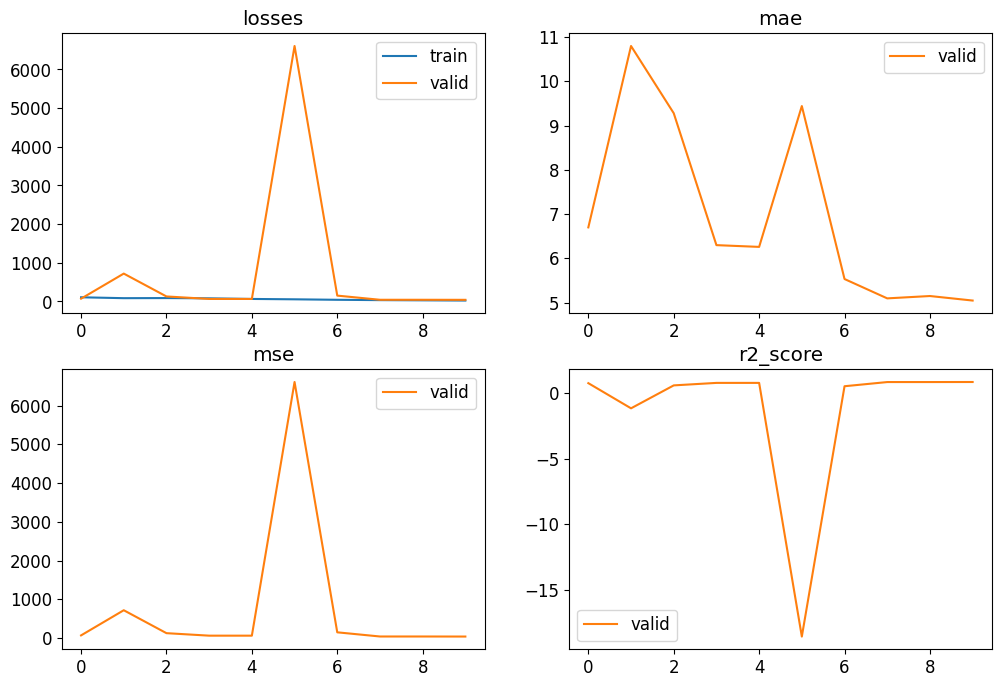

In [ ]:
learn4.fine_tune(10,base_lr=lrs.valley,cbs=SaveModelCallback())
learn4.recorder.plot_metrics()

In [ ]:
learners.append(learn4)

## <font color='blue'>Conclusiones. ¿Qué conclusiones se pueden extraer en base a toda la experimentación anterior? En caso de que nos enfrentemos a un nuevo problema, ¿qué opción, u opciones, de entre las anteriores, parece a priori la más razonable? ¿Por qué?

In [ ]:
modelos=["Apartado 3.2","Apartado 3.3","Apartado 3.4"]

for i,learn in enumerate(learners):
  error_val,MAE,MS2,R2=learn.validate() #validamos el mejor modelo encontrado en cada apartado
  tabla_resultados.append({
      "Modelo" : modelos[i],
      "Error Validación" : error_val,
      "MAE" : MAE,
      "MSE" : MSE,
      "R2" : R2
  })

#generamos el dataframe con los resultados
tabla=pd.DataFrame(tabla_resultados)

In [ ]:
# Estilizar el DataFrame para centrar las columnas, aumentar el espacio entre ellas y eliminar los índices
styled_df = tabla.style.set_table_styles(
    [{'selector': 'th', 'props': [('text-align', 'center'), ('padding', '10px')]},  # Centrar los encabezados
     {'selector': 'td', 'props': [('text-align', 'center'), ('padding', '10px')]}  # Centrar las celdas y aumentar padding
    ]
).set_table_attributes('style="width: 100%; border-collapse: separate; border-spacing: 10px;"') \

# Mostrar el DataFrame con estilo (en un entorno como Jupyter o similar)
styled_df.hide(axis="index")

Modelo,Error Validación,MAE,MSE,R2
Apartado 3.1,96.085114,7.572215,96.085114,0.715225
Apartado 3.2,167.574341,10.352301,96.085114,0.503347
Apartado 3.3,143.157013,9.675897,96.085114,0.575715
Apartado 3.4,42.655506,5.044747,96.085114,0.873579


* Como se podía uno suponer al inicio, y observando los valores de las tres métricas empleadas, el mejor modelo conseguido sin ninguna duda es el definido en el cuarto apartado, que implica usar `fine_tune` sobre ResNet50 preentrenado, dejando la cabecera que añade por defecto Fastai. En cuanto al resto, le sigue el modelo del 1º apartado, 2º y 3º, respectivamente.

  La razón principal radica en que el modelo preentrenado ha sido entrenado previamente sobre un dataset enorme, aprendiendo una serie de capacidades útiles para prácticamente cualquier dataset de trabajo, por lo que es vital evitar perder dichas capacidades ya aprendidas y simplemente realizar un ajuste fino del backbone para adaptarlos al nuevo dataset de trabajo.

* En cuanto a los modelos del segundo y tercer apartado, simplemente entrenamos la cabecera del modelo, manteniendo intacto el backbone, lo que no es del todo correcto ya que sería necesario adaptarlos al nuevo dataset.

* El segundo mejor modelo conseguido implica entrenar desde cero ResNet50, , aprovechando únicamente la arquitectura que sigue ResNet50, y que entrenándolo durante un nº suficiente de épocas, podremos obtener muy buenos resultados, levemente inferiores a los obtenidos en el cuarto apartado. A pesar de que no empleemos una versión preentrenada, la arquitectura de dicho modelo se ha diseñado cuidadosamente, otorgando la suficiente complejidad y permitiendo que el modelo aprenda las suficientes caraterísticas como para lograr un rendimiento promedio considerable, aunque lo entrenemos desde scratch.

Cabe recalcar que debido a la complejidad de ResNet50, no es recomendable entrenarlo durante muchas épocas ya que el riesgo de sobreajuste es alto. En mi caso, me he limitado a usar únicamente **10 épocas**, aunque podría haber incrementado dicho valor y emplear `EarlyStopping` para detener el entrenamiento cuando el modelo empiece a sobreajustarse en exceso.

In [ ]:
best_learn=learn4

# Evaluación del mejor modelo sobre test

Procedemos a evaluar el modelo seleccionado (cuarto apartado) sobre el conjunto de test, para poder evaluar su rendimiento final.

Comenzaremos preparando los datos de test.

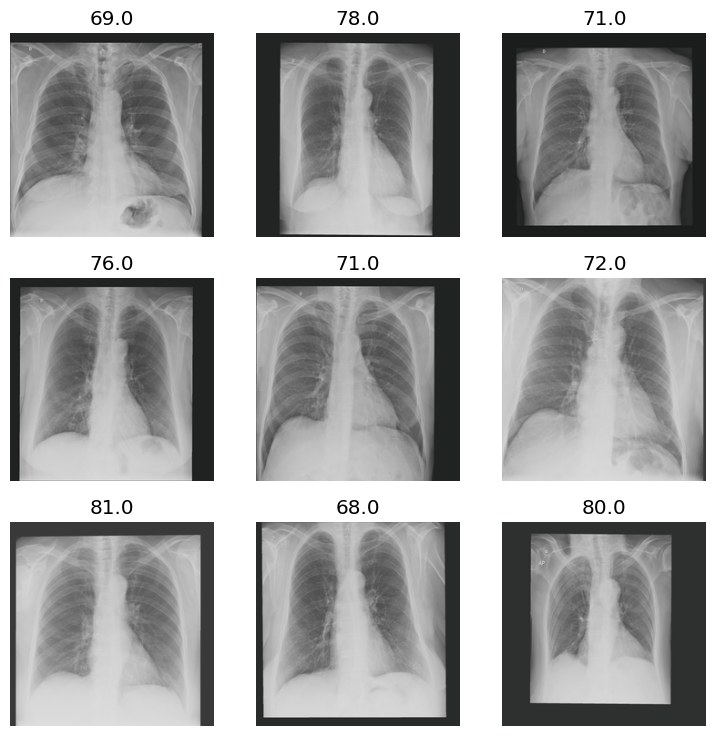

In [ ]:
#generamos dataloader de test, indicando with_labels=True, para generar la etiqueta de cada imagen de test
test_dl = best_learn.dls.test_dl(get_image_files(test_path),with_labels=True)
test_dl.show_batch()

In [ ]:
# Obtener las predicciones del modelo en el conjunto de prueba
preds, targs = best_learn.get_preds(dl=test_dl)

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import r2_score
# Calcular las métricas definidas (en este caso, MAE, MSE y R2)
mae_value = mean_absolute_error(targs, preds)
mse_value = mean_squared_error(targs, preds)
r2_value = r2_score(targs, preds)

# Imprimir los resultados
print(f"Error de test (MAE): {mae_value:.4f}")
print(f"Error de test (MSE): {mse_value:.4f}")
print(f"R2 Score: {r2_value:.4f}")

Error de test (MAE): 4.6579
Error de test (MSE): 35.3688
R2 Score: 0.9083


Se han obtenido valores de MAE y MSE muy bajos y un coeficiente de determinación próximo a 1, lo que implica que nuestro modelo es capaz de explicar casi en su totalidad la variabilidad presente en los datos. En conclusión, el rendimiento conseguido es bastante bueno.

# ¿Por qué podemos reutilizar un modelo preentrenado en un problema de clasificación sobre nuestro problema de regresión?

Hemos usado un modelo entrenado inicialmente sobre un problema de clasificación, ImageNet, sobre nuestro problema de regresión. Esto no presenta ningún inconveniente, siempre y cuando adaptemos la cabecera del modelo en función del problema sobre el que trabajemos.

 Dicho modelo preentrenado ha aprendido a reconocer a partir del dataset original una serie de características que son útiles de forma genérica, independientemente de que estemos tratando un problema de clasificación o regresión, cuya diferencia radica básicamente en la estructura de la cabecera del modelo:
 * En problemas de regresión, se debe especificar la función de pérdida CrossEntrophy, que permitirá interpretar las salidas del modelo como probabilidades de que pertenezca a las diferentes clases.
 * En problemas de regresión, se debe especificar la función de pérdida MSE, reconociendo las salidas del modelo como valores continuos.